# Наивный Байес
Наивный Байес использует теорему Байеса: $P(y|x) = \frac{P(x|y)P(y)}{P(x)}$. Предполагается условная независимость признаков, поэтому $P(x|y)=\prod_{j=1}^{p} P(x_j|y)$. В случае GaussianNB каждый признак моделируется нормальным распределением $\mathcal{N}(\mu_{y,j}, \sigma_{y,j}^2)$. Класс выбирается по правилу максимума апостериорной вероятности: $\hat{y} = \arg\max_y \log P(y) + \sum_j \log P(x_j|y)$.


## Используемые библиотеки
Используем `numpy`, `pandas` для работы с данными. Из `sklearn` — датасет `load_iris`, `train_test_split`, `GaussianNB` и метрики: accuracy, precision, recall, F1, confusion_matrix.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [2]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
HEATMAP_CMAP = "coolwarm"
CONFUSION_CMAP = "Blues"


## Датасет: описание и частичная распечатка
Датасет **Iris** — классический бенчмарк в ML. 150 образцов цветков ириса трёх видов (*setosa*, *versicolor*, *virginica*), по 50 на класс. Четыре числовых признака: длина и ширина чашелистика и лепестка (в см). Задача — мультиклассовая классификация (3 класса). Класс *setosa* линейно отделим от других, тогда как *versicolor* и *virginica* частично перекрываются.


In [3]:
iris = load_iris(as_frame=True)
data = iris.frame
print(f"Размерность: {data.shape}")
data.head()


Размерность: (150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Предварительная обработка
Отделяем признаки от целевой переменной. Разбиваем на train/test (80/20) со стратификацией — при малом размере выборки это особенно важно. GaussianNB не требует масштабирования, так как сам оценивает параметры нормального распределения для каждого признака и класса.


In [4]:
features = data.drop(columns=["target"])
target = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)


## Тепловая карта корреляций
Матрица из 5 переменных. Сильно коррелируют длина лепестка и длина чашелистика ($r > 0.87$) — оба несут похожую информацию о виде цветка. Наивный Байес предполагает независимость признаков — корреляции нарушают это допущение, однако на практике модель часто показывает хорошие результаты даже при умеренных корреляциях.


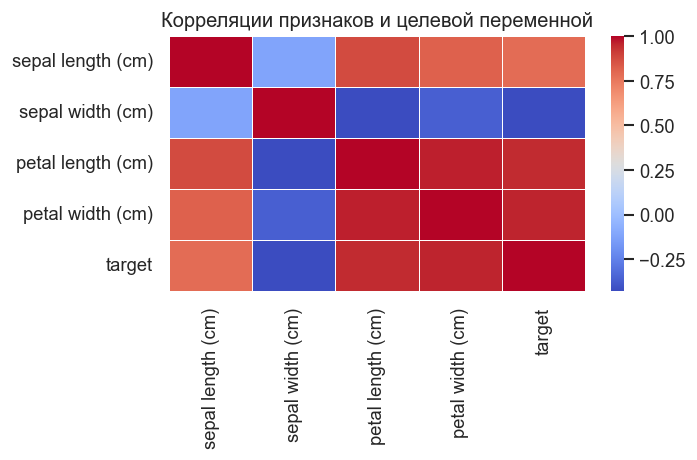

In [5]:
plt.figure(figsize=(6, 4))
correlation = data.corr()
sns.heatmap(correlation, annot=False, cmap=HEATMAP_CMAP, linewidths=0.5)
plt.title("Корреляции признаков и целевой переменной")
plt.tight_layout()
plt.show()


## Обучение модели
`GaussianNB` не имеет гиперпараметров для настройки. Во время `fit` для каждого класса и каждого признака оцениваются $\mu_{y,j}$ и $\sigma_{y,j}^2$ по обучающим данным. Вероятность апостериори вычисляется аналитически — обучение происходит мгновенно.


In [6]:
model = GaussianNB()
model.fit(X_train, y_train)


GaussianNB()

## Прогнозы модели
Вычисляем метрики в режиме `weighted`, чтобы учесть возможный дисбаланс классов:
- **Accuracy** — общая доля верных предсказаний;
- **Precision/Recall/F1** — усредненные с весами пропорционально числу примеров каждого класса.


In [7]:
y_pred = model.predict(X_test)

print("Gaussian Naive Bayes Metrics")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred, average='weighted'):.3f}")
print(f"F1:        {f1_score(y_test, y_pred, average='weighted'):.3f}")


Gaussian Naive Bayes Metrics
Accuracy:  0.967
Precision: 0.970
Recall:    0.967
F1:        0.967


## Графики выходных результатов
**График 1. Матрица ошибок.** Для трех классов матрица 3×3. Ожидаем почти идеальную диагональ для *setosa* (линейно отделим), возможные ошибки между *versicolor* и *virginica* — перекрывающиеся классы.

**График 2. Точность по классам.** Наглядно показывает, где модель уверена, а где ошибается. Помогает выбрать стратегию улучшения: аугментация данных для «слабых» классов или смена модели.


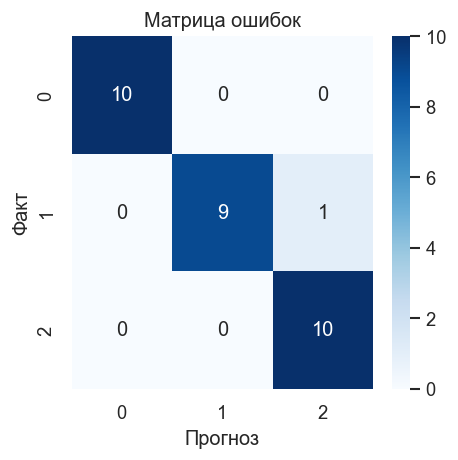

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap=CONFUSION_CMAP)
plt.title("Матрица ошибок")
plt.xlabel("Прогноз")
plt.ylabel("Факт")
plt.tight_layout()
plt.show()


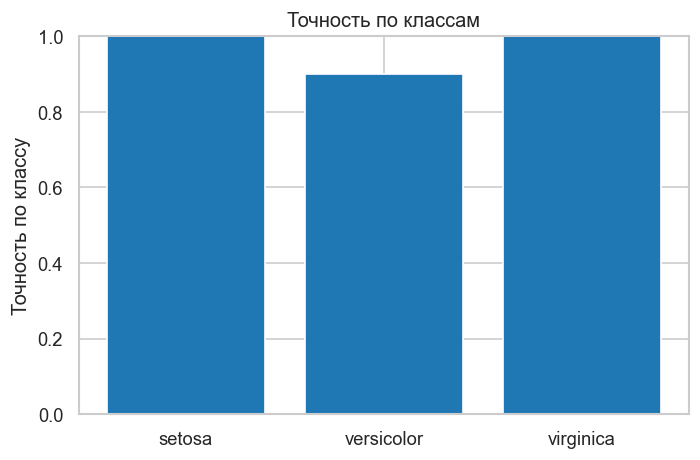

In [9]:
class_names = iris.target_names
per_class_acc = []
for cls in np.unique(y_test):
    mask = y_test == cls
    per_class_acc.append(np.mean(y_pred[mask] == y_test[mask]))

plt.figure(figsize=(6, 4))
plt.bar(class_names, per_class_acc, color=PRIMARY_COLOR)
plt.ylim(0, 1)
plt.ylabel("Точность по классу")
plt.title("Точность по классам")
plt.tight_layout()
plt.show()
